## Условие задачи

Используя схему бегущего счета и итерационные методы, решить задачу для квазилинейного уравнением переноса:

$$\left\{\begin{aligned}
\frac{\partial u}{\partial t} - \frac{1}{1+u}\frac{\partial u}{\partial x}  = 0,\ ~ -1 \leq x < 0\\
u(x,0)= \cos \frac{\pi x}{2}\\
u(0,t) = e^{-t} \\ 
\end{aligned}\\
\right. $$
  


###### Исследование характеристик
В точках пересечения проекций его характеристик, решение будет разрывным. Посмотрим как будут вести себя проекции характеристик в заданных областях. Уравнение характеристик будет иметь вид:
$~~dt=-(1+u)dx$

$\int_{t_o}^{t}dt=\int_{x_o}^{x} -(1+u)dx $

$t=(1+u_0)(x_0-x)+t_0$

Воспользуемся начальным и граничным условиями для получения двух семейств кривых:
    
1) $~~t_0=0: ~~~~~ t=(1+\cos \frac{\pi x_o}{2})(x_0-x)$

2) $~~x_0=0: ~~~~~ t=(1+e^{-t_o})(-x)+t_0$


Импортируем необходимые библиотеки.

In [27]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d

Определим функции характеристик через массивы, где итерирование будет идти по соответствующему неизвестному параметру: $x_0$ или $t_0$  . Здесь $x_0$ и $t_0$ взяты с определенными шагами c помощью np.arange.

In [28]:
def ch1(x):
    return [((1+cos(0.5*pi*x0))*(x0-x)) for x0 in np.arange(-1,0.1,0.1)]

def ch2(x):
    return [((1+exp(-t0))*(-x)+t0) for t0 in np.arange(0,1.1,0.1)]


Создадим массив значений по $x$ от $-1$ до $0$ с определенным шагом и соответсвущие массивы для функций с итерированием уже по $x$. 

In [29]:
x_list = np.arange(-1,0.1,0.1)

ch1_list = [ch1(x) for x in x_list]
ch2_list = [ch2(x) for x in x_list]

Построим соответствующие графики.

<IPython.core.display.Javascript object>


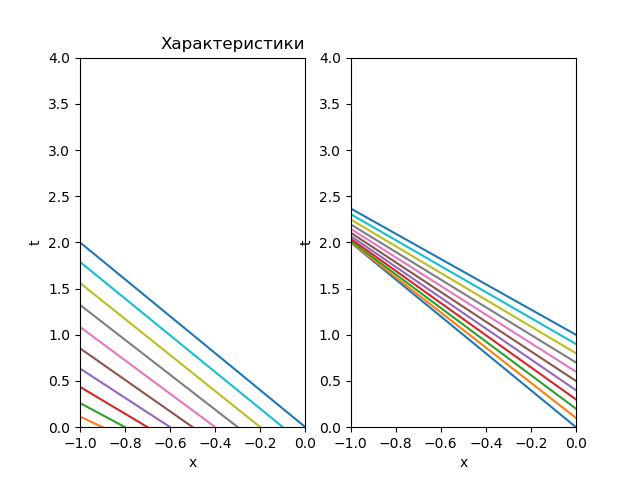

In [39]:
%matplotlib notebook

plt.subplot(1, 2, 1)
plt.ylim(0,4)
plt.xlim(-1,0)
plt.plot(x_list, ch1_list) 
plt.title('Характеристики',loc='right')
plt.ylabel('t')
plt.xlabel('x')
plt.subplot(1, 2, 2)
plt.ylim(0,4)
plt.xlim(-1,0)
plt.plot(x_list, ch2_list) 
plt.ylabel('t')
plt.xlabel('x')


plt.show()


Как видим, в заданных областях пересечений нет. Следовательно, нет так называемого опрокидывания волны, и во всей области решение будет представимо через разностную схему.

# Численное решение

## Сетка
Введем в области $\Omega=\{(x,t):-1\leq x<0,~~0<t<T\} $ сетку с шагом $h_x$ по $x$ и шагом $h_t$ по $t$:
\begin{eqnarray}
\omega_{h_x, ~ h_t}=\begin{cases}
x_n=n\cdot h_x, ~~h_x=\frac{1}{N}, ~~n=\overline{0, N}\\
t_m=m\cdot h_t, ~~h_t=\frac{1}{M}, ~~m=\overline{0, M}
\end{cases}
\end{eqnarray}

На $\omega_{h_x, ~ h_t}$ будем рассматривать сеточную функцию $y^m_{n}=u(x_n,t_m)$

## Шаблон

Перепишем исходное уравнение, приведя его к дивергентному виду: 

$$\frac{\partial u}{\partial t} - \frac{\partial (ln(u+1))}{\partial x} = 0 $$

Для рассматриваемой задачи будем использовать [четырехточечный шаблон](http://math.phys.msu.ru/data/374/tema5.pdf). Он безусловно устойчив и аппроксимирует задачу как $ O({h_x}^2 + {h_t}^2)$.
![Четырехточечный шаблон](4-dots.png "Четырехточечный шаблон")

Таким образом, разностная схема задачи имеет вид:

$$\frac{y^{m+1}_n - y^m_{n} + y^{m+1}_{n+1} - y^m_{n+1}}{2h_t} - \frac{ln(y^{m+1}_{n}+1) - ln(y^{m}_{n}+1) + ln(y^{m+1}_{n+1}+1) - ln(y^{m}_{n+1}+1)}{2h_x}=0$$

Также начальное и граничное условия:

$$\left\{\begin{aligned} 
y^0_n= \cos \frac{\pi n h_x}{2}\\
y^{m}_0 = e^{-m h_t } 
\end{aligned}\\
\right. $$


## Cхема бегущего счета
Данную задачу будем решать при помощи схемы бегущего счета. Значение сеточной функции $ y^{m+1}_{n+1} $ неизвестно, но нам известны все значения, соответствующие начальному( $y^0_n$ ) и граничному( $y^{m}_0$ ) условиям. Таким образом, зная значения в трех соседних точках: $y^{0}_0, y^{0}_1, y^{1}_0$, мы можем численно найти значение в четвертой точке $y^{1}_1$. Зная это значение, мы можем найти по трем известным точкам либо $y^{2}_1$, либо $y^{1}_2$. И так далее, заполняя найденными значениями сетку.  

Также начальное и граничное условия:

$$\left\{\begin{aligned} 
y^0_n= \cos \frac{\pi n h_x}{2}\\
y^{m}_0 = e^{-m h_t } 
\end{aligned}\\
\right. $$

Это неявное уравнение относительно $ y^{m+1}_{n+1} $. Будем решать его [итерационным методом Ньютона](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9D%D1%8C%D1%8E%D1%82%D0%BE%D0%BD%D0%B0).

$$ {y^{m+1}_{n+1}}^{(s+1)} = {y^{m+1}_{n+1}}^{(s)} - \frac{ f({y^{m+1}_{n+1}}^{(s)}) }  { f'({y^{m+1}_{n+1}}^{(s)}) } $$

До достижения заданной точности $ \epsilon $: $$ | {y^{m+1}_{n+1}}^{(s+1)} - {y^{m+1}_{n+1}}^{(s)} | \leq \epsilon $$

## Код

Зададим: $\epsilon$ - точность в методе Ньютона, $N$ - количество шагов по $x$, $М$ - количество шагов по $y$, а также границы нашей сетки. 

In [31]:
epsilon = 0.00001
N = 100; M = 100
T_begin = 0; T_end = 1
X_begin = 0; X_end = -1

Соответственно, элементарные шаги.

In [32]:
h_x=(X_end - X_begin)/(N-1)
h_t=(T_end - T_begin)/(M-1)

Создадим двумерный массив размерами с нашу сетку($N{\times}M$), в ячейках которого будут храниться соответствующие искомые значения.

In [33]:
y=np.zeros((M,N))

Начнем заполнять его начальным и граничным значениями.

In [34]:
for n in np.arange(N):
        y[0][n] = (cos(pi * h_x * n * 0.5))

for m in np.arange(M):
        y[m][0] = exp(-h_t * m)

Для лаконичности определим вспомогательные функции.

In [35]:
def F(m,n):
    return log(y[m][n] + 1)

def df(mp1,np1):
    return (1/(2*h_t) - 0.5/(h_x*(y[mp1][np1]+1)))

Разностная схема будет иметь вид.

In [36]:
def f(mp1, np1):
    n = np1-1
    m = mp1-1
    return (y[mp1][n]-y[m][n] + y[mp1][np1]-y[m][np1]) / (2.*h_t) - (F(mp1, np1)-F(mp1,n) + F(m, np1)-F(m,n)) / (2.*h_x)

Перейдем к методу Ньютона, пробегая по всей сетке.

In [37]:
eps = epsilon + 1; # > epsilon
while eps > epsilon:
    eps = 0
    for m in np.arange(M)[0:M-1]:
        for n in np.arange(N)[0:N-1]:
            ep = f(m+1, n+1) / df( m+1, n+1)
            y[m+1][n+1] = y[m+1][n+1] - ep
            if abs(ep) > eps:
                eps = abs(ep)  

Построим график решения.

<IPython.core.display.Javascript object>


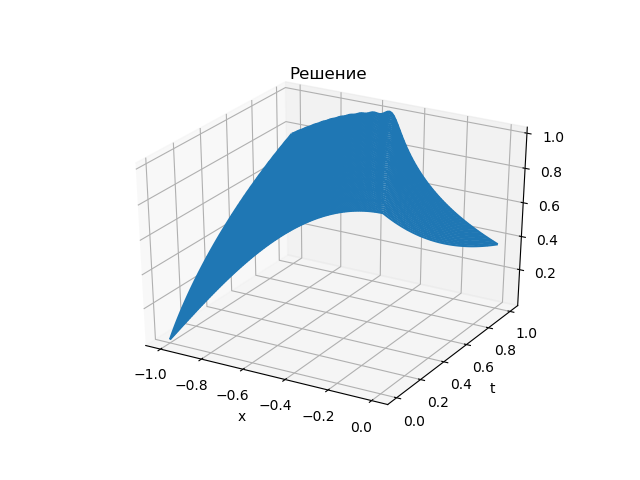

In [38]:
%matplotlib notebook

tm = np.linspace(T_begin,T_end, num=M)
xn = np.linspace(X_begin, X_end, num=N)

X, T = np.meshgrid(xn, tm)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_wireframe(X, T, y, rstride=10,cstride=1)
plt.title('Решение')
plt.xlabel('x')
plt.ylabel('t')
plt.show()


# Дополнительно: устойчивость и аппроксимация


## Устойчивость

### Критерий Неймана(необходимый)

Зафиксируем коэффициент перед $\frac{\partial u}{\partial x}$. Выберем
произвольную точку $(x_0,t_0)$ исследуемой обасти $\Omega$ и
обозначим $-\frac{1}{1+u(x_o~,t_o)}~$ за $С$. Теперь
исследуемая схема приобретет вид: 

$$\begin{aligned}
\frac{U^{m+1}_{n+1}-U^{m}_{n+1}+U^{m+1}_{n}-U^{m}_{n}}{h_t}+C\frac{U^{m+1}_{n+1}-U^{m+1}_{n}+U^{m}_{n+1}-U^{m}_{n}}{h_x}=0\end{aligned}$$

Будем искать решение данного уравнения в виде
$U^m_{n}=\lambda^m e^{i\alpha n}$. Подставив замену в уравнение,
получим: 

$$\begin{aligned}
\lambda e^{i\alpha}-e^{i\alpha}+\lambda -1+\frac{Ch_t}{h_x}(\lambda e^{i\alpha}- \lambda + e^{i\alpha}-1)=0\end{aligned}$$


Тогда для $\lambda$ получим: 

$$\begin{aligned}
\lambda = \frac{e^{i\alpha}+1+\frac{Ch_t}{h_x}(1-e^{i\alpha})}{e^{i\alpha}+1+\frac{Ch_t}{h_x}(e^{i\alpha}-1)}\end{aligned}$$

$$\begin{aligned}
|\lambda | = 1\end{aligned}$$

Из данного соотношения получаем, что
условие $|\lambda(\alpha)|\leq1$ справедливо для любых соотношений шагов по
координате и времени, и, следовательно, спектральный критерий Неймана
выполнен.

### Критерий Куранта(достаточный)

Перепишем исследуемую разностную схему, поставив для нее задачу в виде:

$$\begin{aligned}
\begin{cases}
\frac{U^{m+1}_{n+1}~~-~U^{m}_{n+1}~~+~U^{m+1}_{n}~~-~U^{m}_{n}}{h_t}~~+~C\frac{U^{m+1}_{n+1}~~-~U^{m+1}_{n}~~+~U^{m}_{n+1}~~-~U^{m}_{n}}{h_x}=\epsilon ^{m}_n\\
U^{0}_n=\phi _n\\
U^{m}_0=\mu ^{m}
\end{cases}\end{aligned}$$ 

Преобразуем уравнение к виду:

$$\begin{aligned}
U^{m+1}_{n+1}(1+\frac{Ch_t}{h_x})+U^{m+1}_n(1-\frac{Ch_t}{h_x})=U^{m}_{n+1}(1-\frac{Ch_t}{h_x})+U^{m}_n(1+\frac{Ch_t}{h_x})+h_t \epsilon ^{m}_n\end{aligned},$$где $\epsilon ^{m}_n$ - некоторое возмущение исходной схемы. 

Оценим данное соотношение по равномерной норме: 

$$\begin{aligned}
\|U^{m+1}\|(1+\frac{Ch_t}{h_x})+\|U^{m+1}\|(1-\frac{Ch_t}{h_x}) \leq 
\|U^{m}\|(1-\frac{Ch_t}{h_x})+\|U^{m}\|(1+\frac{Ch_t}{h_x})+h_t \|\epsilon ^{m}\| \notag\end{aligned}$$

$$\begin{aligned}
2\|U^{m+1}\|\leq 2\|U^{m}\| + h_t\|\epsilon\|\end{aligned}$$ 

Тогда по
индукции получаем: $$\begin{aligned}
\| U^m\| \leq \|\phi\| + \frac{mh_t}{2}\|\epsilon\| \\
\| U^m\| \leq \|\phi\| + \frac{T}{2}\|\epsilon\|\end{aligned}$$

Переобозначая: 

$$\begin{aligned}
\| U^m\| \leq \ M|\phi\| + N\|\epsilon\|\end{aligned},$$ 
где $T$ - величина
интервала времени, на котором мы ищем решение, а $M$ и $N$ - константы, не
зависящие от шагов сетки. 

Таким образом получаем, что и критерий Куранта
выполнен для рассматриваемой схемы для любых соотношений шагов по
времени и координате, то есть фактически выполнено определение
устойчивости.


### Геометрический критерий

Рассмотрим исследуемый шаблон. Пусть через точку$(x_{n+1},t^{m+1})$, в
которой ищется значение исследуемой функции, проходит одна из
характеристик. Исходя из того, что в остальных точках шаблона значение
исследуемой функции известно, при любых соотношениях шагов по времени и
координате характеристика пересечет отрезок, соединяющий точки шаблона,
в которых значение исследуемой функции известно.

![Геометрический критерий](geom.jpg "Геометрический критерий")

Таким образом, исследуемая схема является безусловно устойчивой,
согласно условиям Неймана и Куранта.


## Порядок аппроксимации


Вычислим порядок аппроксимации. Для этого разложим значения
функции $U$ в узлах сетки в ряд до члена третьего порядка включительно в
точке $(x_n+\frac{h_x}{2};t_m+\frac{h_t}{2})$: 

$$\begin{aligned}
U^{m+1} = U^{m+0.5}+\frac{h_t}{2}U'~^{m+0.5} + \frac{1}{2}\frac{h^{2}_t}{4} U''~^{m+0.5}+\frac{1}{6}\frac{h^{3}_t}{8}U'''~^{m+0.5} + O(h^{4}_t)\\
U^{m} = U^{m+0.5}-\frac{h_t}{2}U'~^{m+0.5}+\frac{1}{2}\frac{h^{2}_t}{4} U''~^{m+0.5}-\frac{1}{6}\frac{h^{3}_t}{8}U'''~^{m+0.5} + O(h^{4}_t)\\
U_{n+1} = U_{n+0.5}+\frac{h_x}{2}U'_{n+0.5}+\frac{1}{2}\frac{h^{2}_x}{4} U''_{n+0.5}+\frac{1}{6}\frac{h^{3}_x}{8}U'''_{n+0.5} + O(h^{4}_x)\\
U_{n} = U_{n+0.5}-\frac{h_x}{2}U'_{n+0.5}+\frac{1}{2}\frac{h^{2}_x}{4} U''_{n+0.5}-\frac{1}{6}\frac{h^{3}_x}{8}U'''_{n+0.5} + O(h^{4}_x)
\end{aligned}$$

Из данных соотношений получим: 

$$\begin{aligned}
\frac{U^{m+1}_{n+1}-U^{m}_{n+1}+U^{m+1}_n-U^{m}_n}{h_t} +C\frac{U^{m+1}_{n+1}-U^{m+1}_{n}+U^{m}_{n+1}-U^{m}_{n}}{h_x} -\frac{\partial U}{\partial t} -C\frac{\partial U}{\partial x}=O(h^{2}_t + h^{2}_x) \end{aligned}$$

# Основные материалы
1. [Лекции Боголюбова А.А.](https://www.youtube.com/playlist?list=PLcsjsqLLSfNCH9MtnmhIewIAFWmF6Yzex)
2. [Тихонов Н.А., Токмачёв М.Г.  Курс лекций «Основы математического моделирования», часть 2](http://math.phys.msu.ru/data/27/OMM_Part_2.pdf)
3. [Неизвестный файлы на сайте кафедры: темы 1-7](http://math.phys.msu.ru/data/374/tema5.pdf)
4. Документация
